<a href="https://colab.research.google.com/github/KaterinaVat/PINNs/blob/main/pinns(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam

DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(torch.nn.Module):
  def __init__(self, indim = 1, outdim =1):
    super().__init__()
    self.actf = torch.tanh
    self.lin1 = torch.nn.Linear(indim, 100)
    self.lin2 = torch.nn.Linear(100, outdim)

  def forward(self, x):
    x = self.lin1(x)
    x = self.lin2(self.actf(x))
    return x.squeeze()

In [ ]:
class MyData(Dataset):
  def __init__(self, in_tensor, out_tensor):
    self.inp = in_tensor
    self.out = out_tensor

  def __len__(self):
    return len(self.inp)

  def __getitem__(self, idx):
    return self.inp[idx], self.out[idx]

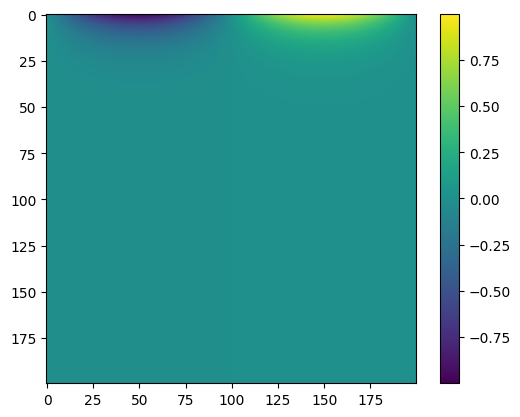

In [ ]:
#generating dataset
def u(x,t):
  return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0, 1, pts)
xs = np.linspace(-1, 1, pts)

X,T = np.meshgrid(xs, ts)
U = u(X,T)
plt.imshow(U)
plt.colorbar()

In [ ]:
#формирование датасета для обучения
# флаттен это преобразование структуры в список не содержащий вложенных элементов
train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype = torch.float32)
# u - действительное значение функции
# a = np.array([[1, 2],[3, 4]])
#  array([1, 2, 3, 4])

# перенос обучения на устройство
train_in.to(DEVICE)
train_out.to(DEVICE)

train_dataset = MyData(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle = True)

In [ ]:
model = Net(indim=2, outdim=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fcn = torch.nn.MSELoss()
epochs = 100

loss_history = []
rel_error_history = []

for epoch in range(epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in.requires_grad_()
        batch_in, batch_out = batch_in.to(DEVICE), batch_out.to(DEVICE)
        model.train()
        def closure():
          optimizer.zero_grad()
          pred = model(batch_in)
          loss = loss_fcn(pred, batch_out)
          loss.backward()
          return loss
        optimizer.step(closure)

        # Накопление статистики
    model.eval()
    epoch_loss = loss_fcn(model(train_in), train_out)
    loss_history.append(epoch_loss.item())
    rel_error = torch.norm(model(train_in)- train_out)/torch.norm(train_out)
    rel_error_history.append(rel_error.item())
    if epoch%5==4:
      print(f"Epoch: {epoch+1} | Loss: {epoch_loss:.4f} | Rel. Error: {rel_error:.4f}")

Epoch: 5 | Loss: 0.0108 | Rel. Error: 0.8854
Epoch: 10 | Loss: 0.0096 | Rel. Error: 0.8350
Epoch: 15 | Loss: 0.0079 | Rel. Error: 0.7580
Epoch: 20 | Loss: 0.0068 | Rel. Error: 0.7021
Epoch: 25 | Loss: 0.0060 | Rel. Error: 0.6577
Epoch: 30 | Loss: 0.0053 | Rel. Error: 0.6219
Epoch: 35 | Loss: 0.0048 | Rel. Error: 0.5895
Epoch: 40 | Loss: 0.0042 | Rel. Error: 0.5496
Epoch: 45 | Loss: 0.0035 | Rel. Error: 0.5020
Epoch: 50 | Loss: 0.0032 | Rel. Error: 0.4774
Epoch: 55 | Loss: 0.0028 | Rel. Error: 0.4499
Epoch: 60 | Loss: 0.0026 | Rel. Error: 0.4333
Epoch: 65 | Loss: 0.0024 | Rel. Error: 0.4127
Epoch: 70 | Loss: 0.0021 | Rel. Error: 0.3863
Epoch: 75 | Loss: 0.0019 | Rel. Error: 0.3712
Epoch: 80 | Loss: 0.0019 | Rel. Error: 0.3694
Epoch: 85 | Loss: 0.0016 | Rel. Error: 0.3377
Epoch: 90 | Loss: 0.0015 | Rel. Error: 0.3249
Epoch: 95 | Loss: 0.0014 | Rel. Error: 0.3134
Epoch: 100 | Loss: 0.0013 | Rel. Error: 0.3014


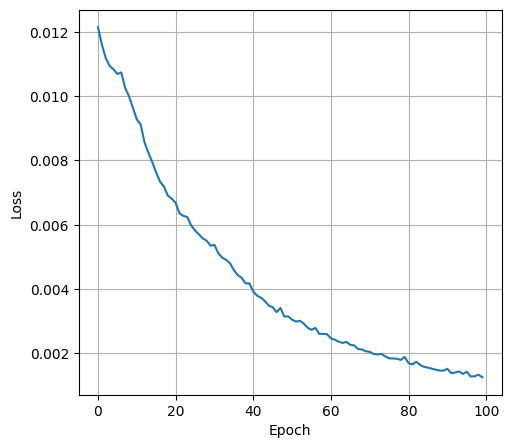

In [ ]:
# График функции потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

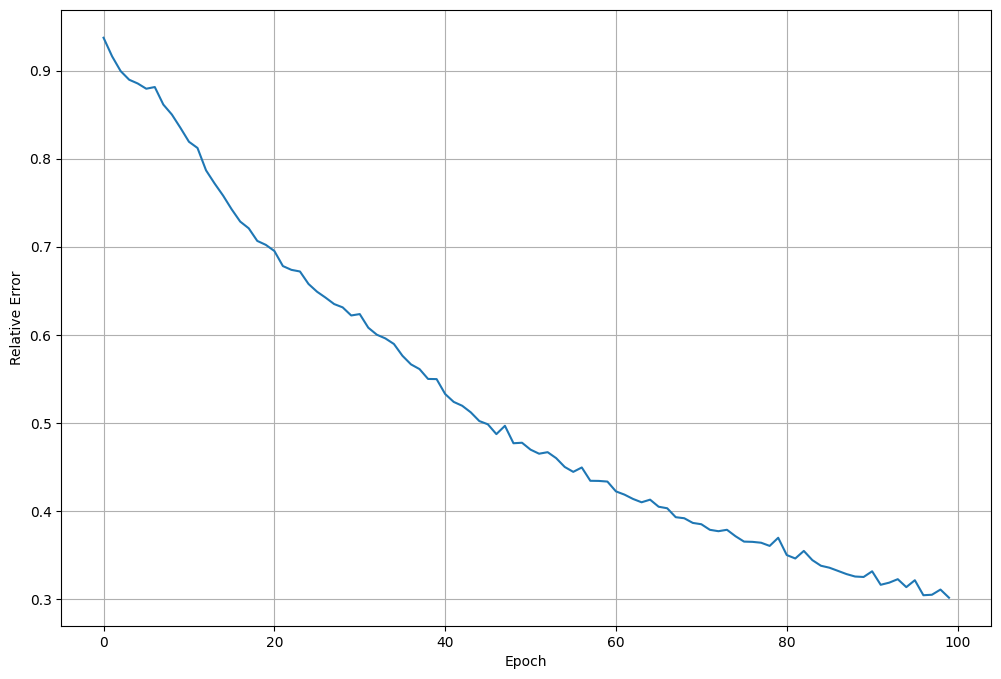

In [ ]:
# График относительной ошибки
plt.figure(figsize=(12,8))
plt.plot(rel_error_history, label="Relative Error (L2)")
plt.xlabel("Epoch")
plt.ylabel("Relative Error")
plt.grid(True)
plt.show()

In [ ]:
#тестирование
# pts = 50
# ts = np.linspace(0.2, 0, pts)
# xs = np.linspace(-5, 5, pts)
# X, T = np.meshgrid(xs, ts)
# X = X.T
# T = T.T

# test_in = torch.tensor([[x,t] for x,t in zip(X.flutten(), T.flutten())], dtype = torch.float32, requires_grad = False)
# test_out = torch.tensor(u(X.flutten(), T.flutten()), dtype = torch.float32)
# test_in.to(DEVICE)
# test_out.to(DEVICE)
# test_pred = model(test_in.to(DEVICE))
# true = test_out
# rel_error_test = torch.norm(pred - true) / torch.norn(true)



что даст нам обученная ранее моделька

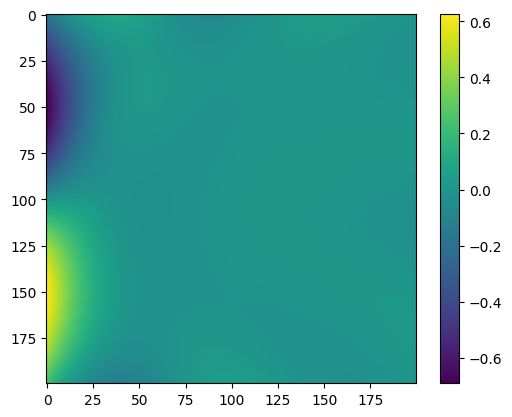

In [ ]:
def u_model(xs, ts):
  pts = torch.tensor(np.array([[x,t] for x,t in zip(xs, ts)]), dtype = torch.float32)
  return model(pts)

pts = 200
ts = np.linspace(0, 1, pts)
xs = np.linspace(-1, 1, pts)
X, T = np.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x,t in zip(X,T):
  img.append(u_model(x,t).detach().numpy().tolist())
  # детач дает возможность просто сохранить результат а не обучать модель

plt.imshow(img)
plt.colorbar()

начнем пинны

In [ ]:
from torch.autograd import grad
# d²u/dx² = 0.5 * du/dt

def phys_loss(inp, out):
  # inp - переменная по которой берется производные - то есть x и t (нужно чтобы брать градиенты по входам)
  # out - предсказание модели. то, по чему берется прозводные du/dx, du^2/dx^2, du/dt
    dudt = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,1]
    dudx = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,0]
    d2udx2 = grad(dudx, inp, grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,0]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

добавление граничных точек
t = 0

In [ ]:
bdry_pts = 200
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])

us_bdry = u(xs_bdry, ts_bdry)

train_in_bd = torch.tensor([[x,t] for x, t in zip(xs_bdry, ts_bdry)],  dtype=torch.float32, requires_grad=True)
train_out_bd = torch.tensor(us_bdry, dtype = torch.float32)

train_in_bd.to(DEVICE)
train_out_bd.to(DEVICE)

tensor([-6.1232e-16, -1.5721e-01, -3.1052e-01, -4.5610e-01, -5.9034e-01,
        -7.0989e-01, -8.1179e-01, -8.9350e-01, -9.5299e-01, -9.8877e-01,
        -9.9997e-01, -9.8629e-01, -9.4809e-01, -8.8630e-01, -8.0247e-01,
        -6.9869e-01, -5.7752e-01, -4.4199e-01, -2.9547e-01, -1.4160e-01,
         1.5786e-02,  1.7278e-01,  3.2549e-01,  4.7009e-01,  6.0301e-01,
         7.2092e-01,  8.2091e-01,  9.0048e-01,  9.5765e-01,  9.9101e-01,
         9.9972e-01,  9.8357e-01,  9.4295e-01,  8.7888e-01,  7.9295e-01,
         6.8730e-01,  5.6456e-01,  4.2778e-01,  2.8036e-01,  1.2596e-01,
        -3.1569e-02, -1.8831e-01, -3.4037e-01, -4.8397e-01, -6.1552e-01,
        -7.3177e-01, -8.2982e-01, -9.0723e-01, -9.6208e-01, -9.9300e-01,
        -9.9922e-01, -9.8059e-01, -9.3758e-01, -8.7124e-01, -7.8324e-01,
        -6.7575e-01, -5.5146e-01, -4.1346e-01, -2.6517e-01, -1.1028e-01,
         4.7343e-02,  2.0379e-01,  3.5517e-01,  4.9772e-01,  6.2789e-01,
         7.4244e-01,  8.3853e-01,  9.1376e-01,  9.6

In [ ]:
from torch.autograd import Variable

In [ ]:

model_pinn = Net(indim=2, outdim=1).to(DEVICE)
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=0.001)
loss_fcn = torch.nn.MSELoss()

# Списки для истории
loss_history = []
base_loss_history = []
phy_loss_history = []
bdry_loss_history = []
rel_error_history = []
phy_error_history = []

for epoch in range(epochs):
    # Фаза обучения
    model_pinn.train()

    for batch_in, batch_out in train_dataloader:
        batch_in = batch_in.to(DEVICE).requires_grad_(True)
        batch_out = batch_out.to(DEVICE)

        optimizer_pinn.zero_grad()
        pred = model_pinn(batch_in).squeeze()

        # Вычисление лоссов
        base_loss = loss_fcn(pred, batch_out)
        phy_loss = phys_loss(batch_in, pred)
        bdry_pred = model_pinn(train_in_bd.to(DEVICE))
        bdry_loss = loss_fcn(bdry_pred, train_out_bd.to(DEVICE))

        total_loss = base_loss + phy_loss + bdry_loss
        total_loss.backward()
        optimizer_pinn.step()

    # Фаза оценки (полностью без градиентов)
    model_pinn.eval()
    with torch.no_grad():
        # Ошибка данных
        pred = model_pinn(train_in.to(DEVICE)).squeeze()
        base_loss = loss_fcn(pred, train_out.to(DEVICE))
        rel_error_data = torch.norm(pred - train_out.to(DEVICE)) / torch.norm(train_out.to(DEVICE))

        # Ошибка граничных условий
        pred_bd = model_pinn(train_in_bd.to(DEVICE))
        bdry_loss = loss_fcn(pred_bd, train_out_bd.to(DEVICE))
        rel_error_bdry = torch.norm(pred_bd - train_out_bd.to(DEVICE)) / torch.norm(train_out_bd.to(DEVICE))

        # Общая относительная ошибка (без физики)
        rel_error = rel_error_data + rel_error_bdry

        # # Физическая ошибка (упрощенный вариант без градиентов)
        # # Для точного расчета нужно делать отдельный проход с градиентами
        # phy_error = torch.tensor(0.0)  # Заглушка, можно заменить на приближенный расчет

    # Отдельный расчет физического лосса (с градиентами)
    model_pinn.eval()  # Но с включенными градиентами
    train_in_phy = train_in.to(DEVICE).requires_grad_(True)
    with torch.enable_grad():
        phy_pred = model_pinn(train_in_phy)
        phy_loss_value = phys_loss(train_in_phy, phy_pred)
        phy_error = torch.norm(phy_loss_value) / (torch.norm(phy_pred))

    # Сохранение истории
    total_loss = base_loss + phy_loss_value + bdry_loss
    loss_history.append(total_loss.item())
    base_loss_history.append(base_loss.item())
    phy_loss_history.append(phy_loss_value.item())
    bdry_loss_history.append(bdry_loss.item())
    rel_error_history.append(rel_error.item())
    phy_error_history.append(phy_error.item())
    # Вывод информации
    if (epoch+1) % 5 == 4:
        print(f'Epoch: {epoch+1:3d} | Loss: {total_loss.item():.4f} '
              f'= Data: {base_loss.item():.4f} '
              f'+ Physics: {phy_loss_value.item():.4f} '
              f'+ Boundary: {bdry_loss.item():.4f} '
              f'| Rel Error: {rel_error.item():.4f} '
              f'| Phy Error: {phy_error.item():.4f}')

Epoch:   4 | Loss: 0.4805 = Data: 0.0133 + Physics: 0.0015 + Boundary: 0.4657 | Rel Error: 1.9488 | Phy Error: 0.0004
Epoch:   9 | Loss: 0.4700 = Data: 0.0109 + Physics: 0.0037 + Boundary: 0.4554 | Rel Error: 1.8445 | Phy Error: 0.0007
Epoch:  14 | Loss: 0.4570 = Data: 0.0092 + Physics: 0.0039 + Boundary: 0.4439 | Rel Error: 1.7606 | Phy Error: 0.0006
Epoch:  19 | Loss: 0.4166 = Data: 0.0088 + Physics: 0.0074 + Boundary: 0.4003 | Rel Error: 1.6937 | Phy Error: 0.0010
Epoch:  24 | Loss: 0.3334 = Data: 0.0107 + Physics: 0.0125 + Boundary: 0.3102 | Rel Error: 1.6692 | Phy Error: 0.0010
Epoch:  29 | Loss: 0.2367 = Data: 0.0116 + Physics: 0.0162 + Boundary: 0.2089 | Rel Error: 1.5627 | Phy Error: 0.0010
Epoch:  34 | Loss: 0.1760 = Data: 0.0127 + Physics: 0.0183 + Boundary: 0.1450 | Rel Error: 1.4995 | Phy Error: 0.0009
Epoch:  39 | Loss: 0.1427 = Data: 0.0129 + Physics: 0.0169 + Boundary: 0.1130 | Rel Error: 1.4412 | Phy Error: 0.0007
Epoch:  44 | Loss: 0.1220 = Data: 0.0116 + Physics: 0.01

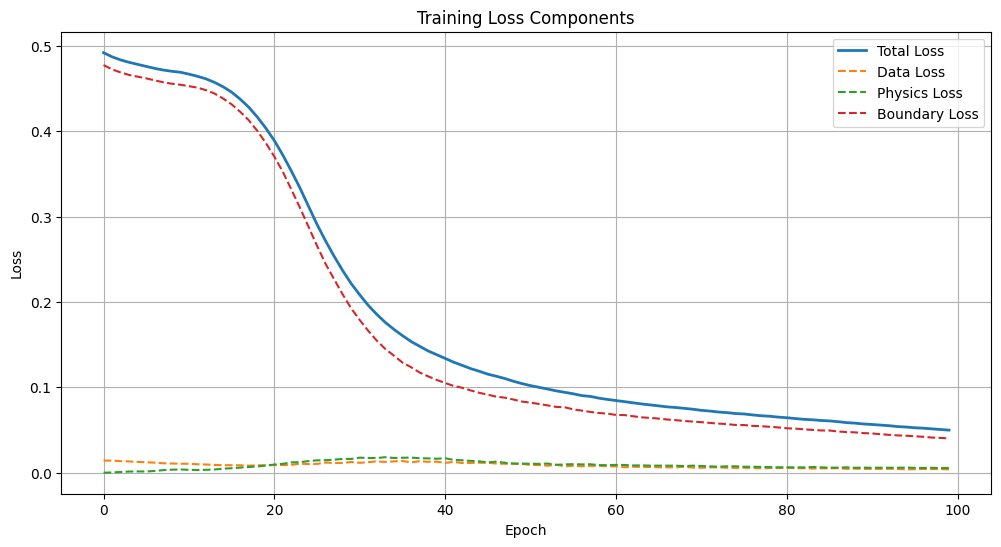

In [ ]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Total Loss', linewidth=2)
plt.plot(base_loss_history, label='Data Loss', linestyle='--')
plt.plot(phy_loss_history, label='Physics Loss', linestyle='--')
plt.plot(bdry_loss_history, label='Boundary Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.grid(True)
plt.show()

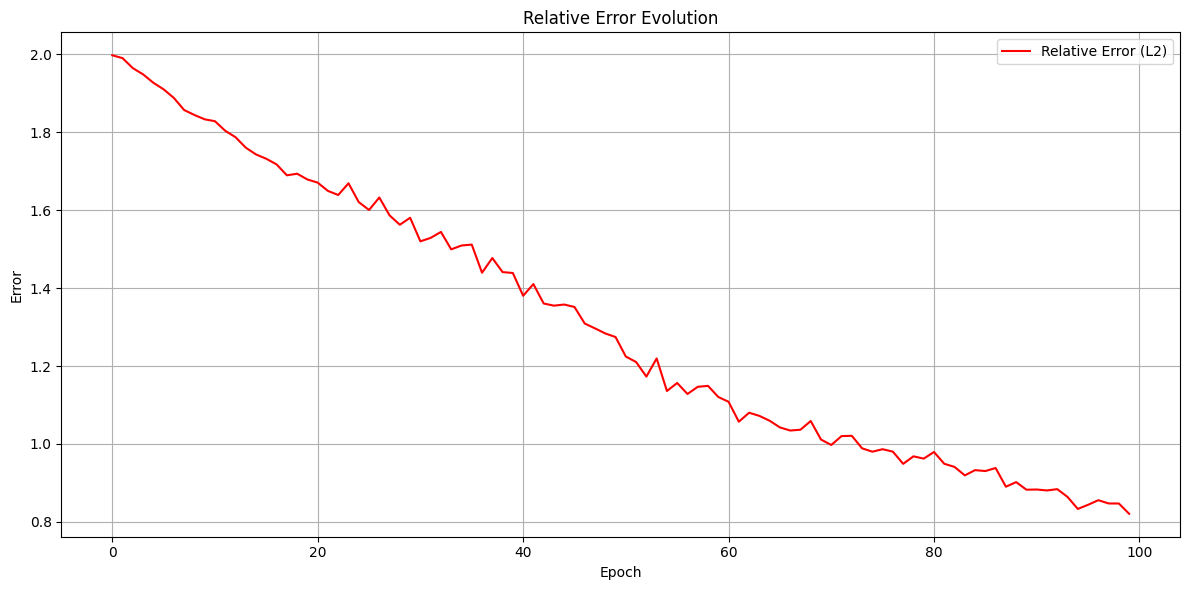

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(rel_error_history, label='Relative Error (L2)', color='red')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Relative Error Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


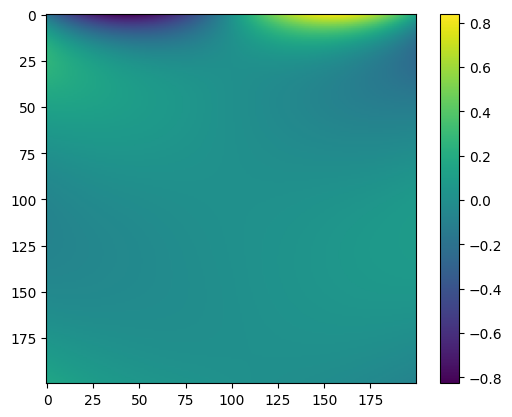

In [ ]:
def u_model_pinn(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0, 1, pts)
xs = torch.linspace(-1, 1, pts)

X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()